In [18]:
#Part C - Simulation and Modeling

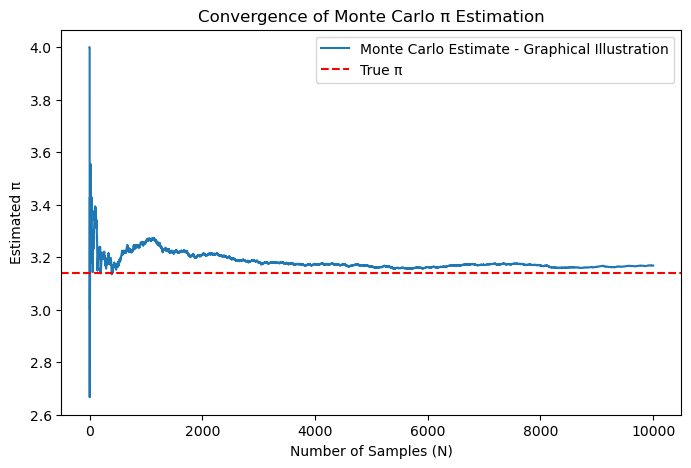

Final estimate of π with N=10000: 3.1684


In [19]:
#1 Monte Carlo pi Estimation
# The following function estimates the value of pi using the Monte Carlo method.
# The method relies on the fact that the ratio of the area of a unit circle (radius = 1) to the area of the square enclosing it (side length = 2) is π/4

import numpy as np
import matplotlib.pyplot as plt

def estimate_pi(num_samples):
    import random
    inside_circle = 0

    for _ in range(num_samples):
        # Generate random points (x, y) in the unit square
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            # Check if the point is inside the unit circle
            inside_circle += 1

    return (inside_circle / num_samples) * 4

# The first function is a implementation using python's random library. The function is slower for large num_samples.
# The second function uses numpy for vectorized operations, which is more efficient for large num_samples

def estimate_pi_np(num_samples, track_progress=False):
    # Compare to the first function, all points are generated at once using numpy
    x = np.random.uniform(-1, 1, num_samples)
    y = np.random.uniform(-1, 1, num_samples)
    # Checking if the points are inside the unit circle
    inside_circle = np.sum(x**2 + y**2 <= 1)

    if track_progress:
        # Tracking the convergence step by step
        pi_estimates = []
        for i in range(1, num_samples + 1):
            # Checking how many points are inside the circle up to the i-th point
            inside_circle_i = np.sum(x[:i]**2 + y[:i]**2 <= 1)
            pi_estimate_i = (inside_circle_i / i) * 4
            pi_estimates.append(pi_estimate_i)
        return (inside_circle / num_samples) * 4, pi_estimates
    
# Probability of a point being inside the circle ≈ inside_circle / num_samples. Since P = π/4, we estimate π as: π ≈ 4 * (inside_circle / num_samples).
    
    
N = 10000
pi_final, estimates = estimate_pi_np(N, track_progress=True)

# Plotting the convergence of the estimates compared with the true value of pi.
plt.figure(figsize=(8,5))
plt.plot(range(1, N+1), estimates, label="Monte Carlo Estimate - Graphical Illustration")
plt.axhline(np.pi, color="red", linestyle="--", label="True π") # True value of π for reference
plt.xlabel("Number of Samples (N)")
plt.ylabel("Estimated π")
plt.title("Convergence of Monte Carlo π Estimation")
plt.legend()
plt.show()

print(f"Final estimate of π with N={N}: {pi_final}")





In [20]:
#2 Chemistry Inspired Monte Carlo 

# We are going to simulate collisions in a box, which produces random collision energies.
# The collisions would be counted if the energy exceeds a certain threshold.

import numpy as np

# The uniform and normal distributions are mixed based on the provided probabilities. The parameters of the distributions are also randomized for each collision, with the ranges chosen arbitrarily.
# Each collision's parameters are randomly chosen from specified ranges.

import numpy as np

def simulate_collisions_randomized(
    M, threshold, *,
    mix_probs=(0.5, 0.5),           # P(uniform), P(normal) — will be normalized
    uni_low_range=(0.0, 1.0),       # per-collision low  ~ U[low_min,  low_max]
    uni_high_range=(2.0, 5.0),      # per-collision high ~ U[high_min, high_max]
    norm_mu_range=(1.0, 3.0),       # per-collision mu   ~ U[mu_min,   mu_max]
    norm_sigma_range=(0.3, 1.0),    # per-collision sigma~ U[s_min,    s_max]
    clip_at_zero=True,
    track_progress=True
):
    """
    Each collision i:
      1) Randomly choose a distribution type (uniform vs normal) using mix_probs.
      2) Randomize that collision's parameters (its own low/high or its own mu/sigma).
      3) Draw one energy E_i; count E_i >= threshold as reactive.

    Returns:
      If track_progress: (p_hat, energies, reacted, cumulative_p)
      else:              (p_hat, energies, reacted)
    """
    # Normalize mixture probabilities (robust if they don't sum to 1)
    mix_sum = float(mix_probs[0] + mix_probs[1])
    p_uni = (mix_probs[0] / mix_sum) if mix_sum > 0 else 0.5

    # Distribution choice per collision (True = uniform, False = normal)
    choice_uniform = np.random.random(M) < p_uni

    energies = np.empty(M, dtype=float)

    # ----- UNIFORM collisions -----
    n_u = int(choice_uniform.sum())
    if n_u > 0:
        # draw per-collision bounds
        lows  = np.random.uniform(uni_low_range[0],  uni_low_range[1],  size=n_u)
        highs = np.random.uniform(uni_high_range[0], uni_high_range[1], size=n_u)
        # ensure high > low for each collision
        swap = highs <= lows
        highs[swap], lows[swap] = lows[swap], highs[swap]
        # draw one energy per uniform collision with its own [low_i, high_i]
        energies[choice_uniform] = np.random.uniform(lows, highs, size=n_u)

    # ----- NORMAL collisions -----
    n_n = M - n_u
    if n_n > 0:
        mus    = np.random.uniform(norm_mu_range[0],    norm_mu_range[1],    size=n_n)
        sigmas = np.random.uniform(norm_sigma_range[0], norm_sigma_range[1], size=n_n)
        energies[~choice_uniform] = np.random.normal(mus, sigmas, size=n_n)

    # Keep energies physical if desired
    if clip_at_zero:
        energies = np.clip(energies, 0.0, None)

    reacted = energies >= threshold
    p_hat = reacted.mean()  # Monte Carlo estimate of reaction probability

    if track_progress:
        cumulative_p = np.cumsum(reacted) / np.arange(1, M + 1)
        return p_hat, energies, reacted, cumulative_p
    return p_hat, energies, reacted

    